In [1]:
from pymatgen.analysis.interfaces.substrate_analyzer import SubstrateAnalyzer
from pymatgen.analysis.interfaces.coherent_interfaces import CoherentInterfaceBuilder
from pymatgen.analysis.interfaces.zsl import ZSLGenerator
from pymatgen.core.structure import Structure
import crystal_toolkit
import numpy as np
import pandas as pd

ImportError: cannot import name 'ELEMENTS_HO' from 'pymatgen.analysis.pourbaix_diagram' (/home/anton/python3.10_env/notebookenv_3.10/lib/python3.10/site-packages/pymatgen/analysis/pourbaix_diagram.py)

In [99]:
def matches(substrate_bulk, film_bulk, substrate_miller, film_max_miller =4, misfit = 5):
    # Find matches between fixed substrate and film with misfit criterion
    out_list = []
    # out_dic = {'substrate_hkl':None, 'film_hkl':None, 'misfit':None}
    
    sub_analyzer = SubstrateAnalyzer(film_max_miller =film_max_miller)
    sub_analyzer.calculate(film=film_bulk,substrate=substrate_bulk)
    matches = list(sub_analyzer.calculate(film=film_bulk,substrate=substrate_bulk, substrate_millers=[substrate_miller]))


    filtered_matches = []
    film_millers = []
    # Process each match
    for match in matches:
        film_matrix = match.film_transformation
        substrate_matrix = match.substrate_transformation

        # Extract original in-plane lattice vectors from bulk film
        original_vectors = np.array([film_bulk.lattice.matrix[0], 
                                     film_bulk.lattice.matrix[1]])

        # Apply transformation matrix to get new film lattice vectors
        new_vectors = np.dot(film_matrix, original_vectors)

        # Compute misfit (strain) in x and y directions
        misfit_x = round(abs((np.linalg.norm(new_vectors[0]) - np.linalg.norm(original_vectors[0])) / np.linalg.norm(original_vectors[0])),1)
        misfit_y = round(abs((np.linalg.norm(new_vectors[1]) - np.linalg.norm(original_vectors[1])) / np.linalg.norm(original_vectors[1])),1)

        # Apply filtering conditions
        if misfit_x <= misfit and misfit_y <= misfit:
            filtered_matches.append(match)
            if match.film_miller not in film_millers:
                film_millers.append(match.film_miller)
                
                out_list.append([substrate_miller, match.film_miller, [misfit_x, misfit_y], match.von_mises_strain])

                print(f"Film miller: {match.film_miller}")
                print(f"Match area: {match.match_area:.4f}")
                print(f"Von_mises_strain: {match.von_mises_strain:.4f}")
                print(f"Misfit along x: {misfit_x:.4f}")
                print(f"Misfit along y: {misfit_y:.4f}\n\n")
    
    return(out_list)

In [100]:
def create_interfaces(substrate_bulk, film_bulk, substrate_miller, film_miller, film_max_miller = 4, num_sites_limit = 400, gap=  2.0, vacuum_over_film =  15.0, 
                                       film_thickness =  5, substrate_thickness = 7, ):


    # Create a set to track already added interfaces by using a unique identifier (e.g., tuple of properties)
    
    i = -1
    all_interfaces = []
    dic_list = []
  

    zsl = ZSLGenerator(max_area=400,
                  max_area_ratio_tol=0.05,
                  max_length_tol=0.05,
                  max_angle_tol=1,
                  bidirectional=False,
              )

    
    seen_interfaces = set()

    # for film_miller in film_millers:
    if 1:
        cib = CoherentInterfaceBuilder(film_structure=film_bulk,
                                   substrate_structure=substrate_bulk,
                                   film_miller= film_miller,
                                   substrate_miller=substrate_miller,
                                   zslgen=zsl
                                  )

        terminations = cib.terminations
        print(film_miller, terminations)

        for termination in terminations:
            
            interfaces=list(cib.get_interfaces(termination= termination, gap=  gap, vacuum_over_film =  vacuum_over_film, 
                                       film_thickness = film_thickness, substrate_thickness = substrate_thickness, in_layers =  False))
            len(interfaces)
            for interface in interfaces:
                
                # Use a unique identifier for the interface, such as a tuple of (num_sites, termination)
                interface_id = (interface.num_sites, termination)

                # if interface.num_sites <num_sites_limit :
                if interface.num_sites <num_sites_limit and interface_id not in seen_interfaces:
                    dic = {'termination':None, 'n_at':None, 'slab':None}
                    dic['termination'] = termination
                    i+=1
                    all_interfaces.append(interface)
                    seen_interfaces.add(interface_id)
                    
                    t1 = termination[0].replace('/', '')
                    t2 = termination[1].replace('/', '')
                    
                    
                    
                    print(i,'hkl_host: ',substrate_miller, 'hkl_film: ',film_miller, f'Natom: {interface.num_sites}', termination)
                    
                    dic['n_at']= interface.num_sites
                    
                    filename = f'{substrate_bulk.composition.reduced_formula}_{film_bulk.composition.reduced_formula}_{"".join(map(str, substrate_miller))}_{"".join(map(str, film_miller))}_{interface.num_sites}at_{t1}_{t2}'
                    # dir(interface)
                    dic['slab'] = filename
                    
                    interface.to(filename=f'interfaces/{filename}.POSCAR', fmt="poscar")
            
                    dic_list.append(dic)

        return dic_list

           


In [112]:
# Data for LiCoO2 substrate

# substrate_bulk = Structure.from_file("LiCoO2.cif")
# substrate_bulk.add_oxidation_state_by_element({"Co": 3, "Li": 1, "O": -2})
# film_bulk = Structure.from_file("Li.cif")
# film_bulk.add_oxidation_state_by_element({"Li": 1})

# film_bulk = Structure.from_file("Li3PO4.cif")
# film_bulk.add_oxidation_state_by_element({"Li": 1, 'O':-2, 'P':5})

# film_bulk = Structure.from_file("Li2SO4.cif")
# film_bulk.add_oxidation_state_by_element({"Li": 1, 'O':-2, 'S':4})

film_bulk = Structure.from_file("Li2ZnCl4.cif")
film_bulk.add_oxidation_state_by_element({"Li": 1, 'Cl':-1, 'Zn':2})
# film_bulk

output = []
output_i = {'substrate':None, 'film':None, 'substrate_hkl':None, 'film_hkl':None, 'misfit_x, %':None, 'misfit_y, %': None, 'von_mises_strain':None, 'n_at': None, 'substrate_thickness, A':None, 'film_thickness, A':None}

In [113]:
substrate_millers=[(1,0,4), (1,0,0), (0,1,2)]
film_max_miller =4
misfit = 5


substrate = substrate_bulk.composition.reduced_formula
film = film_bulk.composition.reduced_formula

final_dic = {'substrate':substrate,'film':film, 'substrate_miller':[], 'film_miller':[], 'misfit, %':[], 'rel':[]}


for substrate_miller in substrate_millers:
    matches_i = matches(substrate_bulk, film_bulk, substrate_miller, film_max_miller =film_max_miller, misfit = misfit)
    for m in matches_i:
        film_miller = m[1]
        print(m)
        final_dic['substrate_miller'].append(substrate_miller)
        final_dic['film_miller'].append(film_miller)
        final_dic['misfit, %'].append(m[2])

        dic_list =  create_interfaces(substrate_bulk, film_bulk, substrate_miller=substrate_miller, film_miller=film_miller, film_max_miller =film_max_miller)
        # final_dic['rel'].append({f'{substrate_miller}/({film_miller})':dic_list})
        final_dic['rel'].append(dic_list)

print(final_dic)

     
        


Film miller: (1, 0, 0)
Match area: 267.6989
Von_mises_strain: 0.0129
Misfit along x: 2.1000
Misfit along y: 1.0000


[(1, 0, 0), (1, 0, 0), [2.1, 1.0], 0.012868690205719843]
(1, 0, 0) [('Li_Pmmm_2', 'LiCoO2_Pmmm_4'), ('Cl2_Pmmm_1', 'LiCoO2_Pmmm_4'), ('ZnCl2_Pm_3', 'LiCoO2_Pmmm_4'), ('Cl2_Pmmm_2', 'LiCoO2_Pmmm_4'), ('Li_Pmmm_1', 'LiCoO2_Pmmm_4')]
Film miller: (0, 0, 1)
Match area: 279.2978
Von_mises_strain: 0.0148
Misfit along x: 0.2000
Misfit along y: 2.0000


Film miller: (1, 0, 1)
Match area: 206.4762
Von_mises_strain: 0.0011
Misfit along x: 1.0000
Misfit along y: 0.0000


[(0, 1, 2), (0, 0, 1), [0.2, 2.0], 0.01476292926621904]
(0, 0, 1) [('Li_Pmma_4', 'O2_P2_1/m_2'), ('Zn_Pmmm_1', 'O2_P2_1/m_2'), ('Cl2_Pmmm_1', 'O2_P2_1/m_2')]
0 hkl_host:  (0, 1, 2) hkl_film:  (0, 0, 1) Natom: 140 ('Li_Pmma_4', 'O2_P2_1/m_2')
1 hkl_host:  (0, 1, 2) hkl_film:  (0, 0, 1) Natom: 248 ('Li_Pmma_4', 'O2_P2_1/m_2')
2 hkl_host:  (0, 1, 2) hkl_film:  (0, 0, 1) Natom: 264 ('Li_Pmma_4', 'O2_P2_1/m_2')
3 hkl_ho

In [98]:
# LiCoO2/Li2SO4 dict 
lco_lso = {'substrate': 'LiCoO2', 'film': 'Li2SO4', 'substrate_miller': [(1, 0, 4), (1, 0, 4), (1, 0, 0), (0, 1, 2), (0, 1, 2), (0, 1, 2)], 'film_miller': [(0, 0, 1), (3, 1, 0), (1, 0, -1), (0, 0, 1), (1, 0, -1), (1, 0, 0)], 'misfit, %': [[3.0, 1.0], [0.0, 0.0], [1.0842664311096009, 1.0], [2.0000000000000004, 0.0], [2.0000000000000004, 1.0], [2.0000000000000004, 0.0]], 'rel': [[], [{'termination': ('Li2SO4_P1_14', 'LiCoO2_P2/m_4'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_104_310_228at_Li2SO4_P1_14_LiCoO2_P2m_4'}, {'termination': ('Li6S2O9_P1_17', 'LiCoO2_P2/m_4'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_104_310_228at_Li6S2O9_P1_17_LiCoO2_P2m_4'}, {'termination': ('Li3(SO3)2_P1_22', 'LiCoO2_P2/m_4'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_104_310_228at_Li3(SO3)2_P1_22_LiCoO2_P2m_4'}, {'termination': ('Li3S2O7_P1_24', 'LiCoO2_P2/m_4'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_104_310_228at_Li3S2O7_P1_24_LiCoO2_P2m_4'}, {'termination': ('Li8S4O15_P1_27', 'LiCoO2_P2/m_4'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_104_310_228at_Li8S4O15_P1_27_LiCoO2_P2m_4'}, {'termination': ('Li2SO4_P-1_28', 'LiCoO2_P2/m_4'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_104_310_228at_Li2SO4_P-1_28_LiCoO2_P2m_4'}], [{'termination': ('SO2_Pm_3', 'LiCoO2_Pmmm_4'), 'n_at': 292, 'slab': 'LiCoO2_Li2SO4_100_10-1_292at_SO2_Pm_3_LiCoO2_Pmmm_4'}, {'termination': ('SO2_Pm_3', 'LiCoO2_Pmmm_4'), 'n_at': 356, 'slab': 'LiCoO2_Li2SO4_100_10-1_356at_SO2_Pm_3_LiCoO2_Pmmm_4'}, {'termination': ('O2_Pmmm_1', 'LiCoO2_Pmmm_4'), 'n_at': 292, 'slab': 'LiCoO2_Li2SO4_100_10-1_292at_O2_Pmmm_1_LiCoO2_Pmmm_4'}, {'termination': ('O2_Pmmm_1', 'LiCoO2_Pmmm_4'), 'n_at': 356, 'slab': 'LiCoO2_Li2SO4_100_10-1_356at_O2_Pmmm_1_LiCoO2_Pmmm_4'}, {'termination': ('Li_P-1_2', 'LiCoO2_Pmmm_4'), 'n_at': 292, 'slab': 'LiCoO2_Li2SO4_100_10-1_292at_Li_P-1_2_LiCoO2_Pmmm_4'}, {'termination': ('Li_P-1_2', 'LiCoO2_Pmmm_4'), 'n_at': 356, 'slab': 'LiCoO2_Li2SO4_100_10-1_356at_Li_P-1_2_LiCoO2_Pmmm_4'}], [{'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_001_76at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_001_152at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_001_228at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_001_304at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_001_320at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_001_364at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_001_380at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_001_396at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_001_76at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_001_152at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_001_228at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_001_304at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_001_320at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_001_364at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_001_380at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_001_396at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_001_76at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_001_152at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_001_228at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_001_304at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_001_320at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_001_364at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_001_380at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('O2_P-1_2', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_001_396at_O2_P-1_2_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_001_76at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_001_152at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_001_228at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_001_304at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_001_320at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_001_364at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_001_380at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_001_396at_LiSO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_001_76at_LiSO3_P1_5_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_001_152at_LiSO3_P1_5_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_001_228at_LiSO3_P1_5_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_001_304at_LiSO3_P1_5_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_001_320at_LiSO3_P1_5_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_001_364at_LiSO3_P1_5_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_001_380at_LiSO3_P1_5_O2_P2_1m_2'}, {'termination': ('LiSO3_P1_5', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_001_396at_LiSO3_P1_5_O2_P2_1m_2'}], [{'termination': ('SO2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_10-1_152at_SO2_Pm_3_O2_P2_1m_2'}, {'termination': ('SO2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 168, 'slab': 'LiCoO2_Li2SO4_012_10-1_168at_SO2_Pm_3_O2_P2_1m_2'}, {'termination': ('SO2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 184, 'slab': 'LiCoO2_Li2SO4_012_10-1_184at_SO2_Pm_3_O2_P2_1m_2'}, {'termination': ('SO2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 244, 'slab': 'LiCoO2_Li2SO4_012_10-1_244at_SO2_Pm_3_O2_P2_1m_2'}, {'termination': ('SO2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 260, 'slab': 'LiCoO2_Li2SO4_012_10-1_260at_SO2_Pm_3_O2_P2_1m_2'}, {'termination': ('SO2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 336, 'slab': 'LiCoO2_Li2SO4_012_10-1_336at_SO2_Pm_3_O2_P2_1m_2'}, {'termination': ('SO2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 352, 'slab': 'LiCoO2_Li2SO4_012_10-1_352at_SO2_Pm_3_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_10-1_152at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 168, 'slab': 'LiCoO2_Li2SO4_012_10-1_168at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 184, 'slab': 'LiCoO2_Li2SO4_012_10-1_184at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 244, 'slab': 'LiCoO2_Li2SO4_012_10-1_244at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 260, 'slab': 'LiCoO2_Li2SO4_012_10-1_260at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 336, 'slab': 'LiCoO2_Li2SO4_012_10-1_336at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 352, 'slab': 'LiCoO2_Li2SO4_012_10-1_352at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Li_P-1_2', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_10-1_152at_Li_P-1_2_O2_P2_1m_2'}, {'termination': ('Li_P-1_2', 'O2_P2_1/m_2'), 'n_at': 168, 'slab': 'LiCoO2_Li2SO4_012_10-1_168at_Li_P-1_2_O2_P2_1m_2'}, {'termination': ('Li_P-1_2', 'O2_P2_1/m_2'), 'n_at': 184, 'slab': 'LiCoO2_Li2SO4_012_10-1_184at_Li_P-1_2_O2_P2_1m_2'}, {'termination': ('Li_P-1_2', 'O2_P2_1/m_2'), 'n_at': 244, 'slab': 'LiCoO2_Li2SO4_012_10-1_244at_Li_P-1_2_O2_P2_1m_2'}, {'termination': ('Li_P-1_2', 'O2_P2_1/m_2'), 'n_at': 260, 'slab': 'LiCoO2_Li2SO4_012_10-1_260at_Li_P-1_2_O2_P2_1m_2'}, {'termination': ('Li_P-1_2', 'O2_P2_1/m_2'), 'n_at': 336, 'slab': 'LiCoO2_Li2SO4_012_10-1_336at_Li_P-1_2_O2_P2_1m_2'}, {'termination': ('Li_P-1_2', 'O2_P2_1/m_2'), 'n_at': 352, 'slab': 'LiCoO2_Li2SO4_012_10-1_352at_Li_P-1_2_O2_P2_1m_2'}], [{'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_100_76at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_100_152at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 212, 'slab': 'LiCoO2_Li2SO4_012_100_212at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_100_228at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li2SO4_012_100_288at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_100_304at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_100_320at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_100_364at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_100_380at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pc_4', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_100_396at_Li2O2_Pc_4_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_100_76at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_100_152at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 212, 'slab': 'LiCoO2_Li2SO4_012_100_212at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_100_228at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li2SO4_012_100_288at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_100_304at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_100_320at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_100_364at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_100_380at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_100_396at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_100_76at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_100_152at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 212, 'slab': 'LiCoO2_Li2SO4_012_100_212at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_100_228at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li2SO4_012_100_288at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_100_304at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_100_320at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_100_364at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_100_380at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO_Pc_4', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_100_396at_SO_Pc_4_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_100_76at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_100_152at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 212, 'slab': 'LiCoO2_Li2SO4_012_100_212at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_100_228at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li2SO4_012_100_288at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_100_304at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_100_320at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_100_364at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_100_380at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('SO2_Pc_6', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_100_396at_SO2_Pc_6_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 76, 'slab': 'LiCoO2_Li2SO4_012_100_76at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 152, 'slab': 'LiCoO2_Li2SO4_012_100_152at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 212, 'slab': 'LiCoO2_Li2SO4_012_100_212at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 228, 'slab': 'LiCoO2_Li2SO4_012_100_228at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li2SO4_012_100_288at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li2SO4_012_100_304at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li2SO4_012_100_320at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 364, 'slab': 'LiCoO2_Li2SO4_012_100_364at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 380, 'slab': 'LiCoO2_Li2SO4_012_100_380at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 396, 'slab': 'LiCoO2_Li2SO4_012_100_396at_Li_P2c_2_O2_P2_1m_2'}]]}

In [110]:
# LiCoO2/Li3PO4 dict 
lco_lpo = {'substrate': 'LiCoO2', 'film': 'Li3PO4', 'substrate_miller': [(1, 0, 4), (0, 1, 2), (0, 1, 2), (0, 1, 2), (0, 1, 2), (0, 1, 2), (0, 1, 2)], 'film_miller': [(3, 1, 0), (0, 1, 0), (0, 2, 1), (1, 0, 1), (1, 2, 1), (3, 1, 0), (3, 2, 0)], 'misfit, %': [[2.0, 0.0], [1.6, 4.0], [4.0, 0.0], [3.1, 1.0], [1.2, 1.0], [2.0, 0.0], [2.0, 0.0]], 'rel': [[{'termination': ('LiPO_P1_3', 'LiCoO2_P2/m_4'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_104_310_384at_LiPO_P1_3_LiCoO2_P2m_4'}, {'termination': ('Li2O3_P1_5', 'LiCoO2_P2/m_4'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_104_310_384at_Li2O3_P1_5_LiCoO2_P2m_4'}, {'termination': ('Li_Cmmm_1', 'LiCoO2_P2/m_4'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_104_310_384at_Li_Cmmm_1_LiCoO2_P2m_4'}], [{'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 96, 'slab': 'LiCoO2_Li3PO4_012_010_96at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_010_144at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 192, 'slab': 'LiCoO2_Li3PO4_012_010_192at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 208, 'slab': 'LiCoO2_Li3PO4_012_010_208at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 240, 'slab': 'LiCoO2_Li3PO4_012_010_240at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 256, 'slab': 'LiCoO2_Li3PO4_012_010_256at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_010_288at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_010_304at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li3PO4_012_010_320at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 336, 'slab': 'LiCoO2_Li3PO4_012_010_336at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 352, 'slab': 'LiCoO2_Li3PO4_012_010_352at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 368, 'slab': 'LiCoO2_Li3PO4_012_010_368at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('O2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_012_010_384at_O2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 96, 'slab': 'LiCoO2_Li3PO4_012_010_96at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_010_144at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 192, 'slab': 'LiCoO2_Li3PO4_012_010_192at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 208, 'slab': 'LiCoO2_Li3PO4_012_010_208at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 240, 'slab': 'LiCoO2_Li3PO4_012_010_240at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 256, 'slab': 'LiCoO2_Li3PO4_012_010_256at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_010_288at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_010_304at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li3PO4_012_010_320at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 336, 'slab': 'LiCoO2_Li3PO4_012_010_336at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 352, 'slab': 'LiCoO2_Li3PO4_012_010_352at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 368, 'slab': 'LiCoO2_Li3PO4_012_010_368at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('LiPO_Pm_3', 'O2_P2_1/m_2'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_012_010_384at_LiPO_Pm_3_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 96, 'slab': 'LiCoO2_Li3PO4_012_010_96at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_010_144at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 192, 'slab': 'LiCoO2_Li3PO4_012_010_192at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 208, 'slab': 'LiCoO2_Li3PO4_012_010_208at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 240, 'slab': 'LiCoO2_Li3PO4_012_010_240at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 256, 'slab': 'LiCoO2_Li3PO4_012_010_256at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_010_288at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_010_304at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li3PO4_012_010_320at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 336, 'slab': 'LiCoO2_Li3PO4_012_010_336at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 352, 'slab': 'LiCoO2_Li3PO4_012_010_352at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 368, 'slab': 'LiCoO2_Li3PO4_012_010_368at_Li2O2_Pm_4_O2_P2_1m_2'}, {'termination': ('Li2O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_012_010_384at_Li2O2_Pm_4_O2_P2_1m_2'}], [{'termination': ('O2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_021_288at_O2_Pm_3_O2_P2_1m_2'}, {'termination': ('O2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_021_304at_O2_Pm_3_O2_P2_1m_2'}, {'termination': ('O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_021_288at_O2_Pm_4_O2_P2_1m_2'}, {'termination': ('O2_Pm_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_021_304at_O2_Pm_4_O2_P2_1m_2'}, {'termination': ('O2_Pm_6', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_021_288at_O2_Pm_6_O2_P2_1m_2'}, {'termination': ('O2_Pm_6', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_021_304at_O2_Pm_6_O2_P2_1m_2'}, {'termination': ('O2_Pm_8', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_021_288at_O2_Pm_8_O2_P2_1m_2'}, {'termination': ('O2_Pm_8', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_021_304at_O2_Pm_8_O2_P2_1m_2'}, {'termination': ('Li3P_Pm_4', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_021_288at_Li3P_Pm_4_O2_P2_1m_2'}, {'termination': ('Li3P_Pm_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_021_304at_Li3P_Pm_4_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_021_288at_O2_P2m_1_O2_P2_1m_2'}, {'termination': ('O2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_021_304at_O2_P2m_1_O2_P2_1m_2'}], [{'termination': ('P_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 160, 'slab': 'LiCoO2_Li3PO4_012_101_160at_P_P2c_2_O2_P2_1m_2'}, {'termination': ('P_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 224, 'slab': 'LiCoO2_Li3PO4_012_101_224at_P_P2c_2_O2_P2_1m_2'}, {'termination': ('P_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 240, 'slab': 'LiCoO2_Li3PO4_012_101_240at_P_P2c_2_O2_P2_1m_2'}, {'termination': ('P_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_101_304at_P_P2c_2_O2_P2_1m_2'}, {'termination': ('P_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li3PO4_012_101_320at_P_P2c_2_O2_P2_1m_2'}, {'termination': ('P_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_012_101_384at_P_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 160, 'slab': 'LiCoO2_Li3PO4_012_101_160at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 224, 'slab': 'LiCoO2_Li3PO4_012_101_224at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 240, 'slab': 'LiCoO2_Li3PO4_012_101_240at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_101_304at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li3PO4_012_101_320at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('O2_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_012_101_384at_O2_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 160, 'slab': 'LiCoO2_Li3PO4_012_101_160at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 224, 'slab': 'LiCoO2_Li3PO4_012_101_224at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 240, 'slab': 'LiCoO2_Li3PO4_012_101_240at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_101_304at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 320, 'slab': 'LiCoO2_Li3PO4_012_101_320at_Li_P2c_2_O2_P2_1m_2'}, {'termination': ('Li_P2/c_2', 'O2_P2_1/m_2'), 'n_at': 384, 'slab': 'LiCoO2_Li3PO4_012_101_384at_Li_P2c_2_O2_P2_1m_2'}], [{'termination': ('O2_P-1_1', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_O2_P-1_1_O2_P2_1m_2'}, {'termination': ('O2_P-1_1', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_O2_P-1_1_O2_P2_1m_2'}, {'termination': ('O2_P-1_1', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_O2_P-1_1_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_2', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_Li2O2_P1_2_O2_P2_1m_2'}, {'termination': ('Li2O_P1_3', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_Li2O_P1_3_O2_P2_1m_2'}, {'termination': ('Li2O_P1_3', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_Li2O_P1_3_O2_P2_1m_2'}, {'termination': ('Li2O_P1_3', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_Li2O_P1_3_O2_P2_1m_2'}, {'termination': ('Li2PO4_P1_7', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_Li2PO4_P1_7_O2_P2_1m_2'}, {'termination': ('Li2PO4_P1_7', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_Li2PO4_P1_7_O2_P2_1m_2'}, {'termination': ('Li2PO4_P1_7', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_Li2PO4_P1_7_O2_P2_1m_2'}, {'termination': ('Li3PO4_P1_8', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_Li3PO4_P1_8_O2_P2_1m_2'}, {'termination': ('Li3PO4_P1_8', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_Li3PO4_P1_8_O2_P2_1m_2'}, {'termination': ('Li3PO4_P1_8', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_Li3PO4_P1_8_O2_P2_1m_2'}, {'termination': ('LiPO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_LiPO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiPO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_LiPO2_P1_4_O2_P2_1m_2'}, {'termination': ('LiPO2_P1_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_LiPO2_P1_4_O2_P2_1m_2'}, {'termination': ('Li_P-1_1', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_Li_P-1_1_O2_P2_1m_2'}, {'termination': ('Li_P-1_1', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_Li_P-1_1_O2_P2_1m_2'}, {'termination': ('Li_P-1_1', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_Li_P-1_1_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_4', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_121_144at_Li2O2_P1_4_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_4', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_121_288at_Li2O2_P1_4_O2_P2_1m_2'}, {'termination': ('Li2O2_P1_4', 'O2_P2_1/m_2'), 'n_at': 304, 'slab': 'LiCoO2_Li3PO4_012_121_304at_Li2O2_P1_4_O2_P2_1m_2'}], [{'termination': ('LiPO_P1_3', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_310_144at_LiPO_P1_3_O2_P2_1m_2'}, {'termination': ('LiPO_P1_3', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_310_288at_LiPO_P1_3_O2_P2_1m_2'}, {'termination': ('Li2O3_P1_5', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_310_144at_Li2O3_P1_5_O2_P2_1m_2'}, {'termination': ('Li2O3_P1_5', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_310_288at_Li2O3_P1_5_O2_P2_1m_2'}, {'termination': ('Li_Cmmm_1', 'O2_P2_1/m_2'), 'n_at': 144, 'slab': 'LiCoO2_Li3PO4_012_310_144at_Li_Cmmm_1_O2_P2_1m_2'}, {'termination': ('Li_Cmmm_1', 'O2_P2_1/m_2'), 'n_at': 288, 'slab': 'LiCoO2_Li3PO4_012_310_288at_Li_Cmmm_1_O2_P2_1m_2'}], [{'termination': ('Li3PO4_P1_48', 'O2_P2_1/m_2'), 'n_at': 208, 'slab': 'LiCoO2_Li3PO4_012_320_208at_Li3PO4_P1_48_O2_P2_1m_2'}, {'termination': ('Li3PO4_P2_1_48', 'O2_P2_1/m_2'), 'n_at': 208, 'slab': 'LiCoO2_Li3PO4_012_320_208at_Li3PO4_P2_1_48_O2_P2_1m_2'}]]}

In [114]:
# LiCoO2/Li2ZnCl4 dict 
lco_lzncl = {'substrate': 'LiCoO2', 'film': 'Li2ZnCl4', 'substrate_miller': [(1, 0, 0), (0, 1, 2), (0, 1, 2)], 'film_miller': [(1, 0, 0), (0, 0, 1), (1, 0, 1)], 'misfit, %': [[2.1, 1.0], [0.2, 2.0], [1.0, 0.0]], 'rel': [[], [{'termination': ('Li_Pmma_4', 'O2_P2_1/m_2'), 'n_at': 140, 'slab': 'LiCoO2_Li2ZnCl4_012_001_140at_Li_Pmma_4_O2_P2_1m_2'}, {'termination': ('Li_Pmma_4', 'O2_P2_1/m_2'), 'n_at': 248, 'slab': 'LiCoO2_Li2ZnCl4_012_001_248at_Li_Pmma_4_O2_P2_1m_2'}, {'termination': ('Li_Pmma_4', 'O2_P2_1/m_2'), 'n_at': 264, 'slab': 'LiCoO2_Li2ZnCl4_012_001_264at_Li_Pmma_4_O2_P2_1m_2'}, {'termination': ('Li_Pmma_4', 'O2_P2_1/m_2'), 'n_at': 280, 'slab': 'LiCoO2_Li2ZnCl4_012_001_280at_Li_Pmma_4_O2_P2_1m_2'}, {'termination': ('Li_Pmma_4', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_001_296at_Li_Pmma_4_O2_P2_1m_2'}, {'termination': ('Li_Pmma_4', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_001_312at_Li_Pmma_4_O2_P2_1m_2'}, {'termination': ('Li_Pmma_4', 'O2_P2_1/m_2'), 'n_at': 388, 'slab': 'LiCoO2_Li2ZnCl4_012_001_388at_Li_Pmma_4_O2_P2_1m_2'}, {'termination': ('Zn_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 140, 'slab': 'LiCoO2_Li2ZnCl4_012_001_140at_Zn_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Zn_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 248, 'slab': 'LiCoO2_Li2ZnCl4_012_001_248at_Zn_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Zn_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 264, 'slab': 'LiCoO2_Li2ZnCl4_012_001_264at_Zn_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Zn_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 280, 'slab': 'LiCoO2_Li2ZnCl4_012_001_280at_Zn_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Zn_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_001_296at_Zn_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Zn_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_001_312at_Zn_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Zn_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 388, 'slab': 'LiCoO2_Li2ZnCl4_012_001_388at_Zn_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Cl2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 140, 'slab': 'LiCoO2_Li2ZnCl4_012_001_140at_Cl2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Cl2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 248, 'slab': 'LiCoO2_Li2ZnCl4_012_001_248at_Cl2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Cl2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 264, 'slab': 'LiCoO2_Li2ZnCl4_012_001_264at_Cl2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Cl2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 280, 'slab': 'LiCoO2_Li2ZnCl4_012_001_280at_Cl2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Cl2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_001_296at_Cl2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Cl2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_001_312at_Cl2_Pmmm_1_O2_P2_1m_2'}, {'termination': ('Cl2_Pmmm_1', 'O2_P2_1/m_2'), 'n_at': 388, 'slab': 'LiCoO2_Li2ZnCl4_012_001_388at_Cl2_Pmmm_1_O2_P2_1m_2'}], [{'termination': ('Li_Cmmm_4', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_101_296at_Li_Cmmm_4_O2_P2_1m_2'}, {'termination': ('Li_Cmmm_4', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_101_312at_Li_Cmmm_4_O2_P2_1m_2'}, {'termination': ('Li_Cmmm_4', 'O2_P2_1/m_2'), 'n_at': 328, 'slab': 'LiCoO2_Li2ZnCl4_012_101_328at_Li_Cmmm_4_O2_P2_1m_2'}, {'termination': ('Cl2_P2/m_2', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_101_296at_Cl2_P2m_2_O2_P2_1m_2'}, {'termination': ('Cl2_P2/m_2', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_101_312at_Cl2_P2m_2_O2_P2_1m_2'}, {'termination': ('Cl2_P2/m_2', 'O2_P2_1/m_2'), 'n_at': 328, 'slab': 'LiCoO2_Li2ZnCl4_012_101_328at_Cl2_P2m_2_O2_P2_1m_2'}, {'termination': ('Cl2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_101_296at_Cl2_Pm_3_O2_P2_1m_2'}, {'termination': ('Cl2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_101_312at_Cl2_Pm_3_O2_P2_1m_2'}, {'termination': ('Cl2_Pm_3', 'O2_P2_1/m_2'), 'n_at': 328, 'slab': 'LiCoO2_Li2ZnCl4_012_101_328at_Cl2_Pm_3_O2_P2_1m_2'}, {'termination': ('Cl2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_101_296at_Cl2_P2m_1_O2_P2_1m_2'}, {'termination': ('Cl2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_101_312at_Cl2_P2m_1_O2_P2_1m_2'}, {'termination': ('Cl2_P2/m_1', 'O2_P2_1/m_2'), 'n_at': 328, 'slab': 'LiCoO2_Li2ZnCl4_012_101_328at_Cl2_P2m_1_O2_P2_1m_2'}, {'termination': ('Li_Cmmm_2', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_101_296at_Li_Cmmm_2_O2_P2_1m_2'}, {'termination': ('Li_Cmmm_2', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_101_312at_Li_Cmmm_2_O2_P2_1m_2'}, {'termination': ('Li_Cmmm_2', 'O2_P2_1/m_2'), 'n_at': 328, 'slab': 'LiCoO2_Li2ZnCl4_012_101_328at_Li_Cmmm_2_O2_P2_1m_2'}, {'termination': ('Li2Cl_Pm_3', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_101_296at_Li2Cl_Pm_3_O2_P2_1m_2'}, {'termination': ('Li2Cl_Pm_3', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_101_312at_Li2Cl_Pm_3_O2_P2_1m_2'}, {'termination': ('Li2Cl_Pm_3', 'O2_P2_1/m_2'), 'n_at': 328, 'slab': 'LiCoO2_Li2ZnCl4_012_101_328at_Li2Cl_Pm_3_O2_P2_1m_2'}, {'termination': ('Li2ZnCl2_Pm_5', 'O2_P2_1/m_2'), 'n_at': 296, 'slab': 'LiCoO2_Li2ZnCl4_012_101_296at_Li2ZnCl2_Pm_5_O2_P2_1m_2'}, {'termination': ('Li2ZnCl2_Pm_5', 'O2_P2_1/m_2'), 'n_at': 312, 'slab': 'LiCoO2_Li2ZnCl4_012_101_312at_Li2ZnCl2_Pm_5_O2_P2_1m_2'}, {'termination': ('Li2ZnCl2_Pm_5', 'O2_P2_1/m_2'), 'n_at': 328, 'slab': 'LiCoO2_Li2ZnCl4_012_101_328at_Li2ZnCl2_Pm_5_O2_P2_1m_2'}]]}

In [115]:
data = lco_lzncl1

name = 'lco_lzncl1
'
# Create a list to store rows
rows = []

# Iterate through substrate_miller, film_miller, and misfit
for i, (sub_miller, film_miller, misfit) in enumerate(zip(data['substrate_miller'], data['film_miller'], data['misfit, %'])):
    # Format Miller indices
    sub_miller_str = f"({''.join(map(str, sub_miller))})"
    film_miller_str = f"({''.join(map(str, film_miller))})"
    misfit_str = ", ".join(map(str, misfit))

    # Add the first row for each combination
    rows.append({
        'Substrate': data['substrate'],
        'Film': data['film'],
        'Substrate Miller': sub_miller_str,
        'Film Miller': film_miller_str,
        'Misfit, %': misfit_str,
        'Termination': None,
        'n_at': None,
        'Slab': None
    })

    # Add rows for terminations if they exist
    if i < len(data['rel']) and data['rel'][i]:
        for term in data['rel'][i]:
            rows.append({
                'Substrate': '',
                'Film': '',
                'Substrate Miller': sub_miller_str,
                'Film Miller': film_miller_str,
                'Misfit, %': misfit_str,
                'Termination': term['termination'],
                'n_at': term['n_at'],
                'Slab': term['slab']
            })

# Create a DataFrame
df = pd.DataFrame(rows)

# Display the table
# print(df.to_string(index=False))
df.to_csv(f'{name}.csv', index=False)

## Li anode coatings

In [ ]:
path_table_coatings = 'data/Li_anode_coatings_tight.csv'
path_table_barriers = 'data/Li_percolation_barriers_MACE.csv'

In [24]:
pwd

'/home/anton/python3.10_env'

In [23]:
table_coatings = pd.read_csv(path_table_coatings)
table_barriers = pd.read_csv(path_table_barriers)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Li_anode_coatings_tight.csv'

In [38]:
table_barriers

,e1d,e2d,e3d,fmax,material_id
0,-1.000000,-1.000000,-1.000000,0.000000,mp-1019606
1,1.854431,2.148865,2.747437,0.081150,mp-1019708
2,-1.000000,-1.000000,-1.000000,0.000000,mp-1019715
3,0.840088,0.840088,1.842285,0.094763,mp-1019778
4,1.625305,2.058472,2.058472,0.086988,mp-1019782
...,...,...,...,...,...
356,0.402542,0.402542,0.402542,0.067395,mp-976280
357,0.617004,2.235840,2.235840,0.090944,mp-976726
358,1.973480,1.973480,1.973480,0.092560,mp-9839
359,0.434143,0.434143,0.434143,0.091123,mp-985585


In [39]:
list_of_compounds = []
for index, row in table_barriers.iterrows():
    e_m = round(row['e3d'],2)
    mat_id = row['material_id']
    if 0 < e_m < 0.6: 
        print(f"Row {index}: Em 3d = {e_m}, material_id = {mat_id}")
        list_of_compounds.append(mat_id)

Row 60: Em 3d = 0.46, material_id = mp-1111672
Row 88: Em 3d = 0.57, material_id = mp-1176564
Row 92: Em 3d = 0.35, material_id = mp-1185301
Row 93: Em 3d = 0.51, material_id = mp-1185319
Row 98: Em 3d = 0.12, material_id = mp-1189725
Row 112: Em 3d = 0.15, material_id = mp-1198740
Row 119: Em 3d = 0.36, material_id = mp-1203004
Row 146: Em 3d = 0.42, material_id = mp-1222669
Row 153: Em 3d = 0.2, material_id = mp-13944
Row 158: Em 3d = 0.28, material_id = mp-14712
Row 159: Em 3d = 0.55, material_id = mp-15254
Row 162: Em 3d = 0.58, material_id = mp-15960
Row 173: Em 3d = 0.56, material_id = mp-22899
Row 175: Em 3d = 0.23, material_id = mp-22961
Row 176: Em 3d = 0.57, material_id = mp-22983
Row 178: Em 3d = 0.56, material_id = mp-23259
Row 180: Em 3d = 0.32, material_id = mp-23416
Row 181: Em 3d = 0.47, material_id = mp-23703
Row 183: Em 3d = 0.59, material_id = mp-23849
Row 186: Em 3d = 0.5, material_id = mp-24585
Row 188: Em 3d = 0.49, material_id = mp-2530
Row 189: Em 3d = 0.38, mat

In [40]:
# list_of_compounds

list_of_compounds_final = []
table_coatings
for index, row in table_coatings.iterrows():
    mat_id = row['material_id']
    if mat_id in list_of_compounds:
        formula = row['formula_pretty']
        print(f'Compound {formula}')

Compound Li3BN2
Compound LiI
Compound LiBeN
Compound LiCl
Compound Li3ScN2
Compound Li3AlN2
Compound LiI
Compound LiH
Compound Li3ClO
Compound Li9S3N
Compound LiBr
Compound Li2Te
Compound LiBr
Compound Li3BN2
Compound LiTmO2
Compound Li2IBr
Compound LiGdO2
Compound LiF
Compound Li3BrO
Compound LiI
Compound Sr2LiCBr3N2


In [41]:
new_df = table_coatings[table_coatings["material_id"].isin(list_of_compounds)]

In [42]:
merged_df = pd.merge(new_df, table_barriers, on="material_id", how="inner")

In [43]:
df_sorted = merged_df.sort_values(by="e3d")

In [44]:
df_sorted

,material_id,crystal_system,space_group,theoretical,reduction_limit,oxidation_limit,reduction_reaction,oxidation_reaction,formula_pretty,chemsys,nsites,energy_above_hull,band_gap,is_stable,e1d,e2d,e3d,fmax
4,mp-542435,Cubic,Ia-3,False,0.0,0.59,8 Li3ScN2 -> 8 Li3ScN2,8 Li3ScN2 -> 8 ScN + 2.667 LiN3 + 21.33 Li,Li3ScN2,Li-N-Sc,48,0.00,2.24,True,0.121826,0.121826,0.121826,0.075864
5,mp-13944,Cubic,Ia-3,False,0.0,0.79,8 Li3AlN2 -> 8 Li3AlN2,8 Li3AlN2 -> 8 AlN + 2.667 LiN3 + 21.33 Li,Li3AlN2,Al-Li-N,48,0.00,2.94,True,0.204834,0.204834,0.204956,0.096252
20,mp-569782,Cubic,Fd-3m,False,0.0,2.14,4 Sr2LiCBr3N2 -> 4 Sr2LiCBr3N2,4 Sr2LiCBr3N2 -> 2 SrCN2 + 6 SrBr2 + 2 N2 + 2 ...,Sr2LiCBr3N2,Br-C-Li-N-Sr,36,0.00,3.97,True,0.276169,0.276169,0.276169,0.078636
17,mp-1185301,Hexagonal,P6_3mc,True,0.0,6.33,2 LiF -> 2 LiF,2 LiF -> F2 + 2 Li,LiF,F-Li,4,0.02,7.48,False,0.349426,0.349426,0.349426,0.098843
16,mp-754204,Tetragonal,I4_1/amd,True,0.0,2.93,2 LiGdO2 -> 2 LiGdO2,2 LiGdO2 -> 0.5 Li2O2 + Gd2O3 + Li,LiGdO2,Gd-Li-O,8,0.04,2.88,False,0.365967,0.365967,0.365967,0.070564
0,mp-8926,Tetragonal,P4_2/mnm,False,0.0,0.87,2 Li3BN2 -> 2 Li3BN2,2 Li3BN2 -> 2 BN + 0.6667 LiN3 + 5.333 Li,Li3BN2,B-Li-N,12,0.00,3.45,False,0.376404,0.376404,0.376404,0.088945
12,mp-976280,Hexagonal,P6_3mc,True,0.0,3.67,2 LiBr -> 2 LiBr,2 LiBr -> 2 Br + 2 Li,LiBr,Br-Li,4,0.00,4.94,True,0.402542,0.402542,0.402542,0.067395
9,mp-557964,Cubic,Pm-3m,False,0.0,0.48,Li9S3N -> Li3N + 3 Li2S,Li9S3N -> 3 Li2S + 0.3333 LiN3 + 2.667 Li,Li9S3N,Li-N-S,13,0.00,2.43,False,0.419708,0.419708,0.419708,0.075184
15,mp-1222669,Trigonal,P3m1,True,0.0,2.84,Li2IBr -> LiI + LiBr,Li2IBr -> I + LiBr + Li,Li2IBr,Br-I-Li,4,0.01,4.13,False,0.231232,0.231232,0.424622,0.083017
8,mp-985585,Cubic,Pm-3m,True,0.0,2.87,Li3ClO -> Li2O + LiCl,Li3ClO -> 0.25 LiClO4 + 0.75 LiCl + 2 Li,Li3ClO,Cl-Li-O,5,0.03,4.68,False,0.434143,0.434143,0.434143,0.091123


In [15]:
from pymatgen.ext.matproj import MPRester

# Replace 'your_api_key' with your actual Materials Project API key
api_key = "kJhjnOu7tx7q2ddENmIhMexGuOujnGcV"

# Create a MPRester object with the API key
with MPRester(api_key) as mpr:
    # Replace 'mp-8926' with the material_id you want
    # structure = mpr.get_structure_by_material_id("mp-8926")
    docs = mpr.materials.summary.search(material_ids=["mp-8926"],  fields = [
                                        'structure',
                                        'material_id',
                                        'symmetry',
                                        'theoretical'
                                        ])
 
# Print the structure
print(docs[0])


/home/anton/python3.10_env/notebookenv_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving SummaryDoc documents: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

MPDataDoc<SummaryDoc>
symmetry=SymmetryData(crystal_system=<CrystalSystem.tet: 'Tetragonal'>, symbol='P4_2/mnm', number=136, point_group='4/mmm', symprec=0.1, angle_tolerance=5.0, version='2.5.0'),
material_id=MPID(mp-8926),
structure=Structure Summary
Lattice
    abc : 4.61560926 4.61560926 5.16815895
 angles : 90.0 90.0 90.0
 volume : 110.10167705704964
      A : np.float64(4.61560926) np.float64(-0.0) np.float64(0.0)
      B : np.float64(0.0) np.float64(4.61560926) np.float64(0.0)
      C : np.float64(0.0) np.float64(0.0) np.float64(5.16815895)
    pbc : True True True
PeriodicSite: Li (2.308, 0.0, 1.292) [0.5, 0.0, 0.25]
PeriodicSite: Li (2.308, 0.0, 3.876) [0.5, 0.0, 0.75]
PeriodicSite: Li (2.308, 2.308, 0.0) [0.5, 0.5, 0.0]
PeriodicSite: Li (0.0, 0.0, 2.584) [-0.0, -0.0, 0.5]
PeriodicSite: Li (0.0, 2.308, 1.292) [-0.0, 0.5, 0.25]
PeriodicSite: Li (0.0, 2.308, 3.876) [-0.0, 0.5, 0.75]
PeriodicSite: B (2.308, 2.308, 2.584) [0.5, 0.5, 0.5]
PeriodicSite: B (0.0, 0.0, 0.0) [-0.0, -0.0

In [17]:
mpr = MPRester("kJhjnOu7tx7q2ddENmIhMexGuOujnGcV")
ws = mpr.get_wulff_shape("mp-135")

Retrieving SurfacePropDoc documents: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7612.17it/s]


<Figure size 100x200 with 0 Axes>

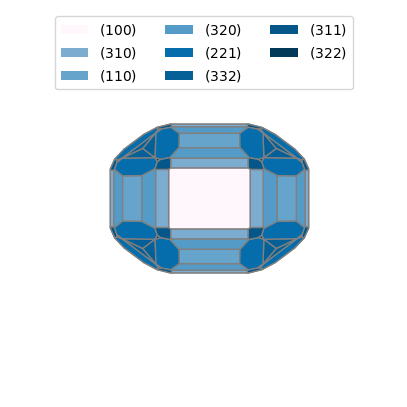

<Figure size 200x100 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(1, 2))  # Width x Height in inches
ax = ws.get_plot()

ax.figure.set_size_inches(5, 15, forward=True)

plt.figure(figsize=(2,1))
plt.show()

In [ ]:
# pymatgen  (2023.6.23) 2023.8.10
# mp-api (0.33.3) -> 0.35.1

In [13]:
!pip install mp_api==0.45.3
# !pip install pydantic==1.10.21
# !pip uninstall pydantic_settings -y


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:


'''
def __init__(self, film_max_miller=1, substrate_max_miller=1, **kwargs):
        """Initialize the substrate analyzer.

        Args:
            zslgen (ZSLGenerator): Defaults to a ZSLGenerator with standard
                tolerances, but can be fed one with custom tolerances
            film_max_miller (int): maximum miller index to generate for film
                surfaces
            substrate_max_miller (int): maximum miller index to generate for
                substrate surfaces.
'''


In [ ]:
 """
    CoherentInterfaceBuilder
    
    Args:
        substrate_structure (Structure): substrate structure
        film_structure (Structure): film structure
        film_miller (tuple[int, int, int]): miller index for the film layer
        substrate_miller (tuple[int, int, int]): miller index for the substrate layer
        zslgen (ZSLGenerator | None): BiDirectionalZSL if you want custom lattice matching tolerances for coherency.
        termination_ftol (float): tolerance to distinguish different terminating atomic planes.
        label_index (bool): If True add an extra index at the beginning of the termination label.
        filter_out_sym_slabs (bool): If True filter out identical slabs with different terminations.
            This might need to be set as False to find more non-identical terminations because slab
            identity separately does not mean combinational identity.
    """

In [ ]:
substrate_miller = (1,0,4)
film_millers = [[0,0,1]]
i = -1
all_interfaces = []


'''
ZSLGenerator(
        max_area_ratio_tol=0.09,
        max_area=400,
        max_length_tol=0.03,
        max_angle_tol=0.01,
        bidirectional=False,
    ):
        """
        Initialize a Zur Super Lattice Generator for a specific film and
            substrate.

        Args:
            max_area_ratio_tol(float): Max tolerance on ratio of
                super-lattices to consider equal
            max_area(float): max super lattice area to generate in search
            max_length_tol: maximum length tolerance in checking if two
                vectors are of nearly the same length
            max_angle_tol: maximum angle tolerance in checking of two sets
                of vectors have nearly the same angle between them.
        """
'''
         

    

In [ ]:
all_interfaces[2]
